# Replication script for the paper "Evaluating coverage and fault detection capability of scenario-based validation of Asmeta specifications"

This script is used to replicate the results of the analyses presented in the paper.

## Data preparation


In [127]:
# Import libraries
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import linregress, spearmanr, shapiro, ttest_rel

Loading the necessary data

We read the file `data.csv` that contains the results of the test generation process with the three approaches: **atgt**, and **evoavalla**, and **random**.

We have two configuration for **random** generation:
- **iterative-random**: progressively increases the number of scenarios and steps until no further improvement is observed in either coverage or mutation score
- **random4atgt**: uses the same number of scenarios and steps as those generated by **atgt**

In [118]:
data = f'data.csv'
model_list_file = f'model_list.txt'
model_list_atgt_valid_file = f'model_list_atgt_valid.txt'

# Read models and valid models for atgt from lists
with open(model_list_file, 'r') as file:
    model_list = [line.strip().replace("\\","/") for line in file.readlines() if line.strip() and not line.lstrip().startswith("//")]
with open(model_list_atgt_valid_file, 'r') as file:
    model_list_atgt_valid = [line.strip().replace("\\","/") for line in file.readlines() if line.strip() and not line.lstrip().startswith("//")]

# Read and filter data, preparing a main df and a df for t test analysis on scenario length
df = pd.read_csv(data, sep=',')
df['asm_path'] = df['asm_path'].str.replace('../../../asm_examples/', '', regex=False)

# Columns of interest
cov_cols = [
    "macro_coverage",
    "update_rule_coverage",
    "forall_rule_coverage",
    "branch_coverage",
    "rule_coverage",
]
# Mapping old mutation operator names to new ones
mutation_rename_map = {
    "ruleremover_score": "rule_remover",
    "chooserulemutator_score": "choose_remover",
    "condremover_score": "condition_remover",
    "condnegator_score": "condition_negator",
    "forallmutator_score": "forall_mutator",
    "partoseqmutator_score": "par_to_seq",
    "seqtoparmutator_score": "seq_to_par",
    "casemutator_score": "case_mutator",
}
mut_cols = list(mutation_rename_map.values())

# Rename columns in both dataframes
df = df.rename(columns=mutation_rename_map)

# Ensure coverage and mutation score columns are numeric (floats). Invalid values become NaN.
for c in cov_cols + mut_cols:
    if c in df.columns:
        df[c] = pd.to_numeric(df[c], errors="coerce")

# Keep only rows of asms in the list
df = df[df['asm_path'].isin(model_list)]

# Keep only rows wit OK status
df = df[df['status'] == "OK"]

# For t-test dataset, keep only rows where approach is 'atgt' or 'random4atgt' and in the list of atgt valid models
df_t_test = df[df['approach'].isin(['random4atgt', 'atgt'])]
df_t_test = df_t_test[df_t_test['asm_path'].isin(model_list_atgt_valid)]

# Exclude rows where approach is 'random' from main df
df = df[df['approach'] != 'random4atgt']

print("Main dataframe shape: ", df.shape)
print("Paired t-test dataframe shape: ", df_t_test.shape)

Main dataframe shape:  (273, 29)
Paired t-test dataframe shape:  (102, 29)


## RQ1 and RQ2: Coverage value and criteria and fault detection capability

macro_coverage
all points:   n=269, slope=0.76593, R²=0.517499, p=3.77e-44, spearman ρ=0.544, pρ=3.69e-22,
cov < 1:      n=58, slope=0.727735, R²=0.620321, p=2.23e-13, spearman ρ=0.705, pρ=6.43e-10


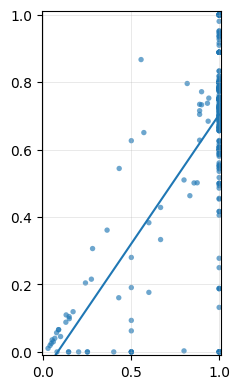

update_rule_coverage
all points:   n=269, slope=0.645834, R²=0.591670, p=7.43e-54, spearman ρ=0.585, pρ=4.78e-26,
cov < 1:      n=118, slope=0.766045, R²=0.740074, p=9.87e-36, spearman ρ=0.771, pρ=1.6e-24


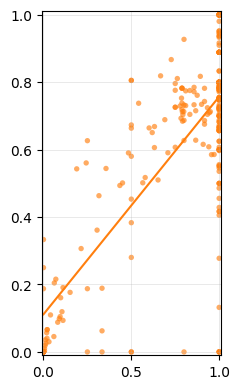

forall_rule_coverage
all points:   n=45, slope=1.01682, R²=0.267756, p=0.000273, spearman ρ=0.402, pρ=0.00625,
cov < 1:      n=44, slope=1.27294, R²=0.295261, p=0.000138, spearman ρ=0.388, pρ=0.00933


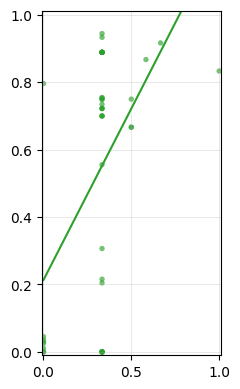

branch_coverage
all points:   n=266, slope=0.731178, R²=0.556835, p=1.46e-48, spearman ρ=0.573, pρ=1.2e-24,
cov < 1:      n=175, slope=0.786945, R²=0.585819, p=6.08e-35, spearman ρ=0.592, pρ=5.8e-18


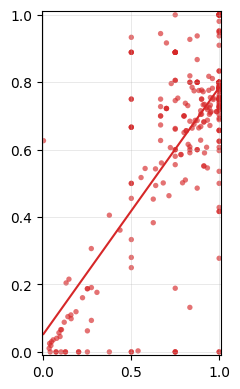

rule_coverage
all points:   n=269, slope=0.753942, R²=0.612824, p=6.02e-57, spearman ρ=0.591, pρ=9.63e-27,
cov < 1:      n=101, slope=0.802711, R²=0.814128, p=5.93e-38, spearman ρ=0.850, pρ=2.66e-29


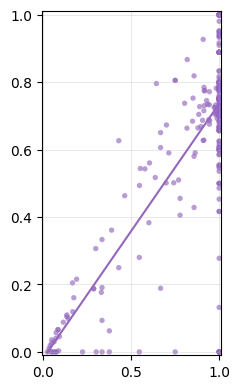

In [ ]:
# Aggregate mutation score per row using mean (skip NaNs)
df["agg_mut_mean"] = df[mut_cols].mean(axis=1, skipna=True)

# Plot colors
cmap = plt.cm.tab10

# For each coverage criteria, compute linear regression and spearman correlation and plot
for i, cov in enumerate(cov_cols):
    color = cmap(i % cmap.N)

    x = df[cov]
    y = df["agg_mut_mean"]

    # drop rows where either x or y is NaN
    mask = x.notna() & y.notna()
    x = x[mask]
    y = y[mask]

    print(cov)

    # Linear regression
    res = linregress(x, y, nan_policy="omit")  # slope, intercept, rvalue, pvalue, stderr
    slope, intercept, r2, p= res.slope, res.intercept, res.rvalue**2, res.pvalue

    # Spearman
    rho, rho_p = spearmanr(x, y, nan_policy="omit")

    print(
        f"all points:   n={x.size}, slope={slope:.6g}, R²={r2:.6f}, p={p:.3g}, "
        f"spearman ρ={rho:.3f}, pρ={rho_p:.3g},"
    )

    # Repeat the analysis excluding coverage == 1
    mask_no1 = mask & (x != 1)
    x_no1 = x[mask_no1]
    y_no1 = y[mask_no1]
    res_no1 = linregress(x_no1, y_no1, nan_policy="omit")
    rho_no1, rho_p_no1 = spearmanr(x_no1, y_no1, nan_policy="omit")
    print(
        f"cov < 1:      n={x_no1.size}, slope={res_no1.slope:.6g}, "
        f"R²={res_no1.rvalue**2:.6f}, p={res_no1.pvalue:.3g}, "
        f"spearman ρ={rho_no1:.3f}, pρ={rho_p_no1:.3g}"
    )

    # Plot
    x_line = np.linspace(np.min(x), np.max(x), 200)
    y_line = intercept + slope * x_line

    fig, ax = plt.subplots(figsize=(2.5, 4))
    ax.scatter(x, y, s=15, alpha=0.65, edgecolors="none", color=color)
    ax.set_ylim(0, 1)
    ax.set_xlim(0, 1)
    ax.plot(x_line, y_line, linewidth=1.5, color=color)

    ax.grid(True, linewidth=0.5, alpha=0.4)

    fig.tight_layout()

    fig.savefig(
        os.path.join("images", f"scatterplot_{cov}.pdf"),
        bbox_inches="tight",
        pad_inches=0
    )

    plt.show()
    plt.close(fig)


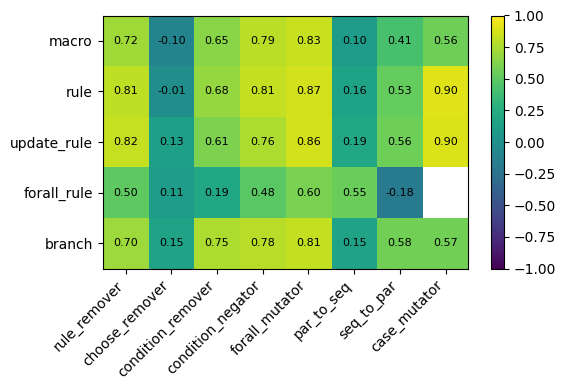

In [ ]:
# Prepara the Pearson correlation matrix: rows = coverages, cols = mutation operators
corr_mat = pd.DataFrame(index=cov_cols, columns=mut_cols, dtype=float)
for cov in cov_cols:
    for mut in mut_cols:
        corr_mat.loc[cov, mut] = df[[cov, mut]].corr(method="pearson").iloc[0, 1]

# Clean labels
corr_mat.columns = [c.replace("_score", "") for c in corr_mat.columns]
corr_mat.index   = [r.replace("_coverage", "") for r in corr_mat.index]

# Desired order
cov_order = [
    "macro",
    "rule",
    "update_rule",
    "forall_rule",
    "branch",
]
corr_mat = corr_mat.loc[cov_order]

# Plot heatmap
fig, ax = plt.subplots(
    figsize=(1.0 + 0.6 * len(corr_mat.columns), 1.5 + 0.5 * len(corr_mat.index))
)

im = ax.imshow(corr_mat.to_numpy(), vmin=-1, vmax=1, aspect="auto")

ax.set_xticks(np.arange(len(corr_mat.columns)))
ax.set_xticklabels(corr_mat.columns, rotation=45, ha="right")

ax.set_yticks(np.arange(len(corr_mat.index)))
ax.set_yticklabels(corr_mat.index)

# Write correlation values in each cell
for i in range(corr_mat.shape[0]):
    for j in range(corr_mat.shape[1]):
        val = corr_mat.iat[i, j]
        if pd.notna(val):
            ax.text(j, i, f"{val:.2f}", ha="center", va="center", fontsize=8)

cbar = fig.colorbar(im, ax=ax)

plt.tight_layout()
fig.savefig(
    os.path.join("images", f"heatmap.pdf"),
    bbox_inches="tight",
    pad_inches=0
)

plt.show()
plt.close(fig)

In [ ]:
'''
# Aggregate mutation score per row using mean (skip NaNs)
df["agg_mut_mean"] = df[mut_cols].mean(axis=1, skipna=True)

for cov in cov_cols:
    # skip if coverage col missing or entirely NaN
    if cov not in df.columns or df[cov].notna().sum() == 0:
        continue

    x = df[cov]        # Series (one value per row)
    y = df[mut_cols]   # DataFrame (N rows, 8 mutation-operator cols)
    n_mut = len(mut_cols)

    # Repeat x for each mutation value (row-wise repetition)
    x_rep = x.loc[x.index.repeat(n_mut)].reset_index(drop=True)

    # Flatten y row-wise to match x_rep
    y_rep = y.to_numpy().reshape(-1)

    # Labels for each point
    mut_labels = np.tile(mut_cols, len(df))

    # 3 plots side-by-side
    fig, axes = plt.subplots(1, 3, figsize=(10, 4))

    # Reduce whitespace between suptitle and subplot titles
    fig.suptitle(f"{cov}")

    # ---- Plot 1: all mutations colored by operator ----
    x_rep_np = x_rep.to_numpy()

    for mut in mut_cols:
        mask = (mut_labels == mut)
        axes[0].scatter(
            x_rep_np[mask],
            y_rep[mask],
            s=20,
            alpha=0.75,
            edgecolors="none",
            label=mut.replace("_score", "")
        )

    axes[0].set_title("all mutations")
    axes[0].set_xlabel("Coverage")
    axes[0].set_ylabel("Mutation score")
    axes[0].set_xlim(0, 1)
    axes[0].set_ylim(0, 1)
    axes[0].grid(True, linewidth=0.5, alpha=0.4)
    axes[0].legend(fontsize=6, frameon=False, loc="upper left")

    # ---- Plot 2: aggregated mean mutation per row ----
    axes[1].scatter(
        x,
        df["agg_mut_mean"],
        s=20,
        alpha=0.75,
        edgecolors="none"
    )
    axes[1].set_title("mean mutation")
    axes[1].set_xlabel("Coverage")
    axes[1].set_xlim(0, 1)
    axes[1].set_ylim(0, 1)
    axes[1].grid(True, linewidth=0.5, alpha=0.4)

    # ---- Plot 3: binned boxplot (10 bins) of coverage vs mean mutation ----
    n_bins = 10
    bin_edges = np.linspace(0, 1, n_bins + 1)

    bins = pd.cut(x, bins=bin_edges, include_lowest=True)

    box_data = [
        df.loc[bins == b, "agg_mut_mean"].values
        for b in bins.cat.categories
    ]

    bp = axes[2].boxplot(
        box_data,
        widths=0.6,
        showfliers=False,
    )

    axes[2].set_title("mean mutation (binned)")
    axes[2].set_xlabel("Coverage bin")
    axes[2].set_ylim(0, 1)
    axes[2].grid(True, linewidth=0.5, alpha=0.4)

    axes[2].set_xticks(range(1, n_bins + 1))
    axes[2].set_xticklabels(
        [
            f"[{0.0:.1f},{b.right:.1f}]" if i == 0
            else f"({b.left:.1f},{b.right:.1f}]"
            for i, b in enumerate(bins.cat.categories)
        ],
        rotation=35,
        ha="right"
    )

    # Tighten spacing + reduce top margin reserved for suptitle
    plt.show()
'''

'\n# Aggregate mutation score per row using mean (skip NaNs)\ndf["agg_mut_mean"] = df[mut_cols].mean(axis=1, skipna=True)\n\nfor cov in cov_cols:\n    # skip if coverage col missing or entirely NaN\n    if cov not in df.columns or df[cov].notna().sum() == 0:\n        continue\n\n    x = df[cov]        # Series (one value per row)\n    y = df[mut_cols]   # DataFrame (N rows, 8 mutation-operator cols)\n    n_mut = len(mut_cols)\n\n    # Repeat x for each mutation value (row-wise repetition)\n    x_rep = x.loc[x.index.repeat(n_mut)].reset_index(drop=True)\n\n    # Flatten y row-wise to match x_rep\n    y_rep = y.to_numpy().reshape(-1)\n\n    # Labels for each point\n    mut_labels = np.tile(mut_cols, len(df))\n\n    # 3 plots side-by-side\n    fig, axes = plt.subplots(1, 3, figsize=(10, 4))\n\n    # Reduce whitespace between suptitle and subplot titles\n    fig.suptitle(f"{cov}")\n\n    # ---- Plot 1: all mutations colored by operator ----\n    x_rep_np = x_rep.to_numpy()\n\n    for mut i

## RQ3: Coverage value and fault detection capability (with equal length)

ATGT df fror t-test shape: (51, 9)
Random df for t-test shape: (51, 9)
Merged df shape: (51, 16)


macro_coverage
51 sample - in 18 atgt coverage is greater than random
Shapiro–Wilk:
W = 0.930389, p = 0.197


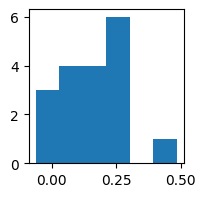

T-Test:
t = 4.715087, p = 0.0002

update_rule_coverage
51 sample - in 36 atgt coverage is greater than random
Shapiro–Wilk:
W = 0.963533, p = 0.276


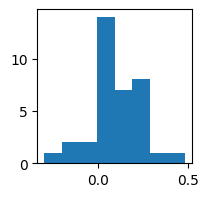

T-Test:
t = 3.999654, p = 0.000313

forall_rule_coverage
0 sample - in 0 atgt coverage is greater than random

branch_coverage
50 sample - in 34 atgt coverage is greater than random
Shapiro–Wilk:
W = 0.962883, p = 0.294


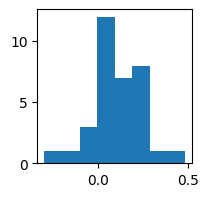

T-Test:
t = 4.224935, p = 0.000177

rule_coverage
51 sample - in 34 atgt coverage is greater than random
Shapiro–Wilk:
W = 0.954767, p = 0.17


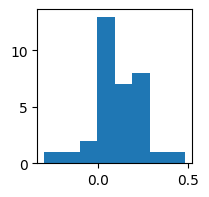

T-Test:
t = 4.381619, p = 0.000113

agg_cov_mean
51 sample - in 39 atgt coverage is greater than random
Shapiro–Wilk:
W = 0.965130, p = 0.263


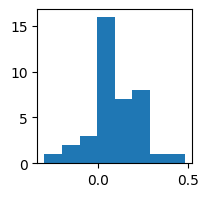

T-Test:
t = 3.943025, p = 0.000334


In [146]:
# Aggregate mutation score and coverages per row using mean (skip NaNs)
df_t_test["agg_mut_mean"] = df_t_test[mut_cols].mean(axis=1, skipna=True)
df_t_test["agg_cov_mean"] = df_t_test[cov_cols].mean(axis=1, skipna=True)

# Prepara one df for each approach
cols_to_keep = cov_cols + ["agg_mut_mean", "agg_cov_mean"]
keys = ["asm_name", "asm_path"]
df_atgt = (
    df_t_test[df_t_test["approach"] == "atgt"]
    .loc[:, keys + cols_to_keep]
    .rename(columns={c: f"{c}_atgt" for c in cols_to_keep})
)
df_random = (
    df_t_test[df_t_test["approach"] == "random4atgt"]
    .loc[:, keys + cols_to_keep]
    .rename(columns={c: f"{c}_random4atgt" for c in cols_to_keep})
)

print("ATGT df fror t-test shape:", df_atgt.shape)
print("Random df for t-test shape:", df_random.shape)

# Merge the two df
merged_df = df_atgt.merge(
    df_random,
    on=keys,
)

print("Merged df shape:", merged_df.shape)

# Check the number of sample for which atgt coverage is greater than random
print()
for cov in cov_cols + ["agg_cov_mean"]:
    print()
    print(cov)
    mask_not_na = (
        merged_df[cov + "_atgt"].notna()
        & merged_df[cov + "_random4atgt"].notna()
    )
    mask_not_na_g = mask_not_na & (merged_df[cov + "_atgt"] > merged_df[cov + "_random4atgt"])
    print(f"{mask_not_na.sum()} sample - in {mask_not_na_g.sum()} atgt coverage is greater than random")

    if (mask_not_na_g.sum() > 0):
        masked_df = merged_df[mask_not_na_g]

        # Check for normality of the differences of mean mutations
        diff = (masked_df["agg_mut_mean_atgt"] - masked_df["agg_mut_mean_random4atgt"]).dropna()

        # Shapiro–Wilk normality test
        W, p_shapiro = shapiro(diff.to_numpy())
        print("Shapiro–Wilk:")
        print(f"W = {W:.6f}, p = {p_shapiro:.3g}")

        # Distribution (visual check)
        plt.figure(figsize=(2, 2))
        plt.hist(diff.to_numpy(), bins="auto")
        plt.show()

        # Paired t-test on mean mutation
        t_stat, p_value = ttest_rel(masked_df["agg_mut_mean_atgt"], masked_df["agg_mut_mean_random4atgt"])
        print("T-Test:")
        print(f"t = {t_stat:.6f}, p = {p_value:.3g}")
